<a href="https://colab.research.google.com/github/doctorpeppercokebear/image_classification/blob/main/Resnet50v2_squared_5class_622.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 구글 드라이브 연동

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 압축풀기

In [3]:
!unzip -q "/content/drive/MyDrive/PetHealthCheck/data/dog_eye_tr_te_va_squared_all_5class_622.zip"

## 모듈 불러오기


### 그래프 한글 안 깨지게 하는 코드

In [16]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths='/content/drive/MyDrive/PetHealthCheck/D2Coding')
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.rc('font', family='D2Coding')

### 라이브러리 임포트

In [5]:
import tensorflow as tf
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, AveragePooling2D, concatenate
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # 모델 저장, 조기종료

import matplotlib.pyplot as plt
import numpy as np
import os




## 데이터 전처리



```
classes_labels= [
    '궤양성각막질환',
    '백내장',
    '안검종양',
    '핵경화',
    '정상'
]

```

위 라벨만 남기고 삭제 후 학습 진행


In [6]:
import os

base_dir = '/content/dog_eye_tr_te_va_squared_all_5class_622'

for root, dirs, files in os.walk(base_dir):
    if root != base_dir:  # base_dir 자체는 제외
        num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
        print(f"{os.path.basename(root)}: {num_images} images")

val: 0 images
궤양성각막질환: 3093 images
백내장: 4641 images
안검종양: 1077 images
핵경화: 2159 images
정상: 17027 images
train: 0 images
궤양성각막질환: 74216 images
백내장: 111416 images
안검종양: 25840 images
핵경화: 51824 images
정상: 51083 images
test: 0 images
궤양성각막질환: 3093 images
백내장: 4644 images
안검종양: 1078 images
핵경화: 2161 images
정상: 17029 images


In [9]:
import glob
import random
import os
import shutil

# 샘플링할 클래스 이름들
target_classes = [
    '궤양성각막질환',
    '백내장',
    '안검종양',
    '정상',
    '핵경화',
]

# 샘플링할 이미지 개수
target_num_images = 25800

# 기본 경로
base_dir = "/content/dog_eye_tr_te_va_squared_all_5class_622/train"

for target_class in target_classes:
    # 대상 디렉토리
    target_dir = os.path.join(base_dir, target_class)

    # 해당 클래스의 모든 이미지 경로를 가져옴
    image_paths = glob.glob(os.path.join(target_dir, "*.jpg")) + glob.glob(os.path.join(target_dir, "*.png"))

    # 이미지 개수가 이미 적은 경우
    if len(image_paths) <= target_num_images:
        print(f"{target_class} 클래스의 이미지가 이미 {target_num_images}개 이하입니다.")
    else:
        # 랜덤하게 이미지를 선택
        selected_images = random.sample(image_paths, target_num_images)

        # 선택된 이미지를 제외한 나머지 이미지를 삭제
        for image_path in image_paths:
            if image_path not in selected_images:
                os.remove(image_path)

        print(f"{target_class} 클래스의 이미지를 {target_num_images}개로 줄였습니다.")


궤양성각막질환 클래스의 이미지를 25800개로 줄였습니다.
백내장 클래스의 이미지를 25800개로 줄였습니다.
안검종양 클래스의 이미지를 25800개로 줄였습니다.
정상 클래스의 이미지를 25800개로 줄였습니다.
핵경화 클래스의 이미지를 25800개로 줄였습니다.


In [10]:
import os

base_dir = '/content/dog_eye_tr_te_va_squared_all_5class_622/train'

for root, dirs, files in os.walk(base_dir):
    if root != base_dir:  # base_dir 자체는 제외
        num_images = sum(1 for file in files if file.endswith('.jpg') or file.endswith('.png'))  # jpg, png 이미지 확인
        print(f"{os.path.basename(root)}: {num_images} images")

궤양성각막질환: 25800 images
백내장: 25800 images
안검종양: 25800 images
핵경화: 25800 images
정상: 25800 images


### 하이퍼파라미터 설정



In [13]:
batch_size = 32
img_size = 224
learning_rate = 1e-4    # 기존 5e-4 에서 1e-4로 조절
epochs = 40


classes_labels= [
    '궤양성각막질환',
    '백내장',
    '안검종양',
    '정상',
    '핵경화',
]

num_classes = len(classes_labels)
base_dir = '/content/dog_eye_tr_te_va_squared_all_5class_622'

### 이미지 증강

In [14]:
# 이미지 증강이 적용된 데이터 제너레이터 선언
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,         # 이미지를 무작위로 20도까지 회전
    width_shift_range=0.2,     # 가로 이동 범위를 20%로 늘림
    height_shift_range=0.2,    # 세로 이동 범위를 20%로 늘림
    shear_range=0.2,           # 이미지를 20% 범위 내에서 엇갈리게 변형
    zoom_range=0.2,            # 확대/축소 범위를 20%로 늘림
    horizontal_flip=True,
    brightness_range=[0.8, 1.2] # 밝기를 80% ~ 120% 범위에서 무작위 조절
)

validation_datagen = ImageDataGenerator(
    rescale=1. / 255,          # 검증 데이터에도 동일한 정규화 적용
)

test_datagen = ImageDataGenerator(
    rescale=1. / 255          # 테스트 데이터에도 동일한 정규화 적용
)

# flow_from_directory: 디렉토리에서 이미지를 불러와 배치 단위로 제공
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  # 훈련 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),    # 검증 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical',        # 다중 클래스 분류이므로 'categorical' 설정
    follow_links=True        # 숨김 파일 무시
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),   # 테스트 데이터 디렉토리 경로
    target_size=(img_size, img_size), # 이미지 크기 조정 (224x224)
    batch_size=batch_size,           # 배치 크기 설정 (32)
    class_mode='categorical'         # 다중 클래스 분류이므로 'categorical' 설정
)


Found 129032 images belonging to 5 classes.
Found 27999 images belonging to 5 classes.
Found 28006 images belonging to 5 classes.


### 이미지 확인

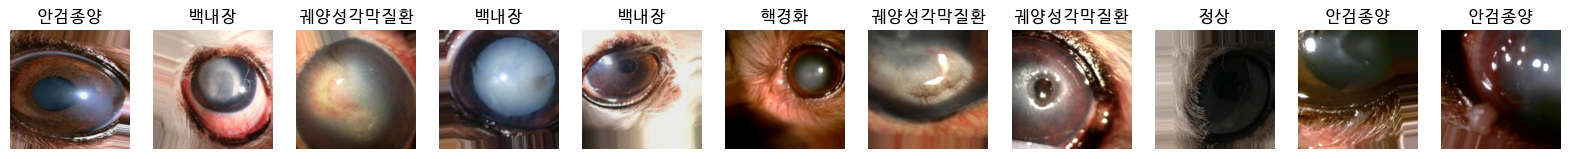

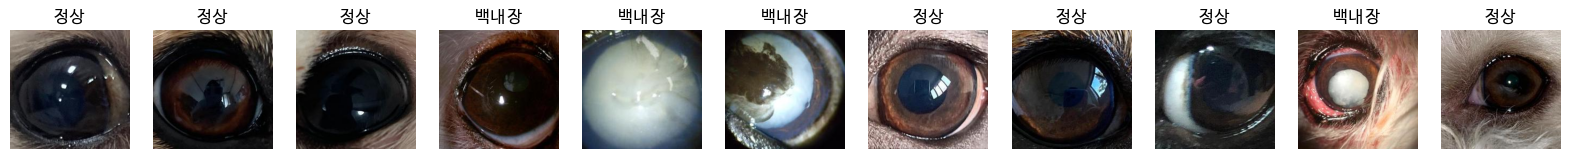

In [17]:
def show_images(generator, num_images=11):
    image, labels = next(generator)
    plt.figure(figsize=(20, 20))  # 이미지 개수에 따라 figsize 조절

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image[i])

        # 클래스 레이블에 맞는 제목 설정
        class_index = np.argmax(labels[i])  # one-hot encoded labels에서 클래스 인덱스 추출

        # Check if class_index is within the range of classes_labels
        if class_index >= len(classes_labels):
            class_index = 0

        class_name = classes_labels[class_index]
        plt.title(class_name)

        plt.axis('off')
    plt.show()

show_images(train_generator, num_images=11)  # 모든 클래스 이미지 확인
show_images(test_generator, num_images=11)

## 모델 구현
* ResNet50v2 사용


In [18]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(img_size, img_size, 3),  # 입력 이미지 크기 (224x224x3)
    include_top=False,                    # 사전 학습된 모델의 마지막 분류 레이어 제외
    weights='imagenet',                   # ImageNet 데이터셋으로 사전 학습된 가중치 사용
    pooling='avg'                         # 특징 맵을 평균 풀링하여 1차원 벡터로 변환
)

inputs = base_model.input                 # 입력 레이어 설정 (base_model의 입력 사용)
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)  # 128개 노드의 은닉층 추가 (ReLU 활성화 함수 사용)
x = tf.keras.layers.Dropout(0.4)(x)       # 과적합 방지를 위한 드롭아웃 레이어 추가 (기존 10% 드롭아웃 -> 40%로 증가)
outputs = tf.keras.layers.Dense(5, activation='softmax')(x)  # 출력 레이어 설정 (클래스 개수만큼 출력 노드, softmax 활성화 함수 사용)

# 모델 정의
model = tf.keras.Model(inputs=inputs, outputs=outputs)  # 입력과 출력을 연결하여 모델 생성

model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,717 (90.90 MB)

 Trainable params: 23,782,277 (90.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

### 모델 컴파일링


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# 옵티마이저 설정
# Adam 옵티마이저를 설정합니다. learning_rate는 학습률입니다.
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# 콜백 함수 설정
# 학습 중 특정 조건이 만족되면 호출되는 함수들입니다.
callback = [
    # val_loss를 모니터링하여 개선이 없을 때 학습률을 감소시키는 콜백
    ReduceLROnPlateau(
        monitor='val_loss',  # 모니터할 값
        mode='min',          # 최소화가 목표
        factor=0.1,          # 학습률 감소 비율
        patience=2,          # 개선 없을 때 기다릴 에포크 수
        min_lr=1e-7,         # 학습률의 최솟값
        verbose=1            # 정보 출력 여부
    ),
    # val_loss가 개선될 때마다 모델을 저장하는 콜백
    ModelCheckpoint(
        '/content/drive/MyDrive/PetHealthCheck/dog_eye_622_best.keras',  # 저장 경로
        monitor='val_loss',  # 모니터할 값
        mode='min',          # 최소화가 목표
        save_best_only=True  # 가장 좋은 모델만 저장
    )
]

# 조기 종료 콜백 설정
# val_loss가 개선되지 않으면 조기 종료하여 과대적합을 방지합니다.
early_stopping_cb = EarlyStopping(
    patience=4,              # 개선이 없을 때 기다릴 에포크 수
    restore_best_weights=True,# 가장 좋은 모델의 가중치를 복원
    mode='min',               # 최소화가 목표
    monitor='val_loss'        # 모니터할 값
)

# 모델 컴파일
# 모델을 학습할 수 있도록 설정합니다.
model.compile(
    optimizer=optimizer,      # 설정한 Adam 옵티마이저 사용
    loss='categorical_crossentropy',# 다중 클래스 분류를 위한 손실 함수
    metrics=[                 # 모델의 성능을 평가할 지표들
        'accuracy',           # 정확도
        tf.keras.metrics.Precision(), # 정밀도
        tf.keras.metrics.Recall(),    # 재현율
        tf.keras.metrics.AUC()        # ROC AUC
    ]
)

## 모델 학습'


In [20]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[callback, early_stopping_cb]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 1714s 410ms/step - accuracy: 0.6648 - auc: 0.9114 - loss: 0.8149 - precision: 0.7528 - recall: 0.5468 - val_accuracy: 0.8531 - val_auc: 0.9834 - val_loss: 0.3536 - val_precision: 0.8803 - val_recall: 0.8299 - learning_rate: 1.0000e-04
Epoch 2/40
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 1605s 398ms/step - accuracy: 0.7672 - auc: 0.9570 - loss: 0.5730 - precision: 0.8144 - recall: 0.7065 - val_accuracy: 0.8872 - val_auc: 0.9884 - val_loss: 0.2903 - val_precision: 0.9015 - val_recall: 0.8765 - learning_rate: 1.0000e-04
Epoch 3/40
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 1606s 398ms/step - accuracy: 0.7930 - auc: 0.9657 - loss: 0.5090 - precision: 0.8309 - recall: 0.7460 - val_accuracy: 0.8816 - val_auc: 0.9885 - val_loss: 0.2856 - val_precision: 0.9030 - val_recall: 0.8634 - learning_rate: 1.0000e-04
Epoch 4/40
4033/4033 ━━━━━━━━━━━━━━━━━━━━ 1614s 400ms/step - accuracy: 0.8116 - auc: 0.9713 - loss: 0.4621 - precision: 0.8420 - recall: 0.7751 - val_accuracy: 0.8822 - 

## 평가지표


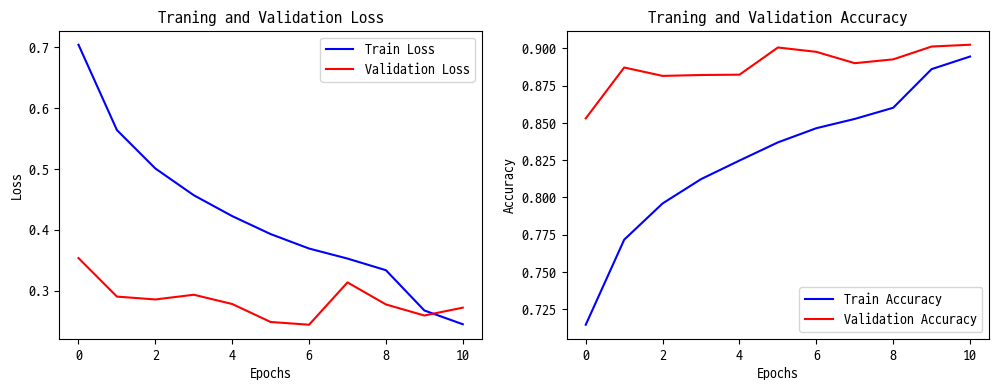

In [21]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color="blue")
plt.plot(history.history['val_loss'], label='Validation Loss', color="red")
plt.title('Traning and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color="blue")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="red")
plt.title('Traning and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
# prompt: .h5 모델로 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/PetHealthCheck/dog_eye_model_best_622.h5')


In [ ]:
# prompt: /content/drive/MyDrive/CV_project/안구질환_모델/ 이 경로의 모델을 저장하는 코드 알려줘

model.save('/content/drive/MyDrive/PetHealthCheck/Resnet_squared_b64')


In [24]:
trained_model = tf.keras.models.load_model('/content/drive/MyDrive/PetHealthCheck/dog_eye_model_best_622.h5')

trained_model.evaluate(test_generator)

876/876 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.8966 - auc: 0.9905 - loss: 0.2518 - precision: 0.9040 - recall: 0.8898


[0.24896599352359772,
 0.896165132522583,
 0.9036397933959961,
 0.8900235891342163,
 0.9907873868942261]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━

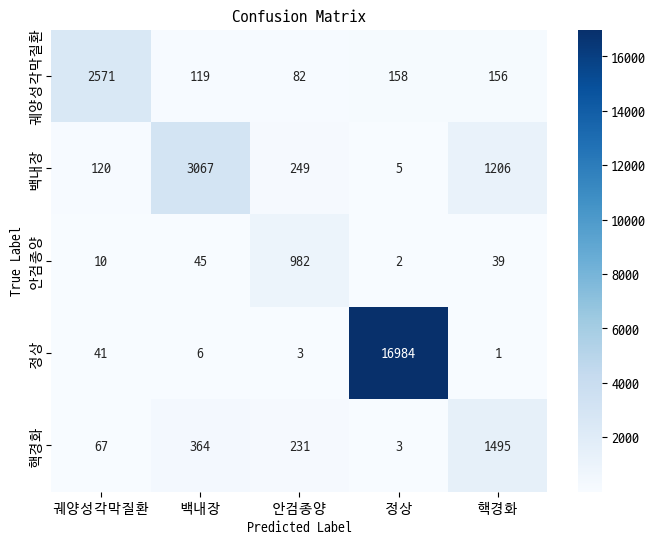

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 테스트 데이터의 실제 레이블과 모델 예측값 가져오기
test_labels = []
test_predictions = []

# test_generator는 배치 단위로 데이터를 제공하므로, 모든 배치를 순회하며 데이터 추출
for i in range(len(test_generator)):
    images, labels = next(test_generator)
    predictions = trained_model.predict(images)

    # 실제 레이블 (원-핫 인코딩 해제)
    test_labels.extend(np.argmax(labels, axis=1))
    # 모델 예측값 (확률에서 클래스 인덱스로 변환)
    test_predictions.extend(np.argmax(predictions, axis=1))

# 혼돈 행렬 생성
cm = confusion_matrix(test_labels, test_predictions)

# 혼돈 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_labels, yticklabels=classes_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()